### Data Process and Graph Building for Voting Prediction of UN

In [66]:
import pandas as pd
import json

voting_data_path = 'data/UN_DATA.csv'

# read in the data
df = pd.read_csv(voting_data_path)

<ipython-input-66-3a16c8f4106e>:7: DtypeWarning: Columns (228,229,230,232,235,236,238,239,240,241,242,243,245,246,247,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(voting_data_path)


In [90]:
org_data_path = 'data/org_list.json'

org_list = json.load(open(org_data_path))

conversion_dict = {
    'RUSSIA': 'RUSSIAN FEDERATION',
    'VIETNAM': 'VIET NAM',
    'TANZANIA': 'UNITED REPUBLIC OF TANZANIA',
    'SOUTH KOREA': 'REPUBLIC OF KOREA',
    'BRUNEI': 'BRUNEI DARUSSALAM',
    'CONGO (KINSHASA)': 'DEMOCRATIC REPUBLIC OF THE CONGO',
    'UAE': 'UNITED ARAB EMIRATES',
    'THE BAHAMAS': 'BAHAMAS',
    'MICRONESIA': 'MICRONESIA (FEDERATED STATES OF)',
    'NORTH KOREA': 'DEMOCRATIC PEOPLE\'S REPUBLIC OF KOREA'
    
}

In [94]:
# get the title line
title_line = df.columns.values.tolist()

print(title_line)

voters = title_line[11:]
resolutions = df['Title'].tolist()

print(len(voters))
print(len(resolutions))
print(voters)

['Council', 'Date', 'Title', 'Resolution', 'TOTAL VOTES', 'NO-VOTE COUNT', 'ABSENT COUNT', 'NO COUNT', 'YES COUNT', 'Link', 'token', 'SENEGAL', 'MALAYSIA', 'VENEZUELA (BOLIVARIAN REPUBLIC OF)', 'UNITED KINGDOM', 'RUSSIAN FEDERATION', 'JAPAN', 'ANGOLA', 'URUGUAY', 'SPAIN', 'EGYPT', 'NEW ZEALAND', 'UNITED STATES', 'FRANCE', 'CHINA', 'UKRAINE', 'NIGER', 'SAINT VINCENT AND THE GRENADINES', 'ESTONIA', 'SOUTH AFRICA', 'VIET NAM', 'BELGIUM', 'GERMANY', 'TUNISIA', 'INDONESIA', 'DOMINICAN REPUBLIC', 'BRAZIL', 'UNITED REPUBLIC OF TANZANIA', 'PHILIPPINES', 'ALGERIA', 'BENIN', 'DENMARK', 'ROMANIA', 'ARGENTINA', 'GREECE', 'AUSTRIA', 'SWITZERLAND', 'CYPRUS', 'MOZAMBIQUE', 'SUDAN', 'FIJI', 'BULGARIA', 'CUBA', 'UGANDA', 'ZAMBIA', 'SOUTH SUDAN', 'MONACO', 'REPUBLIC OF KOREA', 'REPUBLIC OF MOLDOVA', 'SAN MARINO', 'YEMEN', 'ITALY', 'BURUNDI', 'HUNGARY', 'CAMBODIA', 'MALAWI', 'NAURU', 'NICARAGUA', 'BRUNEI DARUSSALAM', 'POLAND', 'THAILAND', 'MALDIVES', 'SIERRA LEONE', 'TURKEY', 'CABO VERDE', 'PAPUA NEW GUI

In [99]:
org_index_list = {}
for org_name in org_list:
    members = org_list[org_name]
    members_idx = []
    for c in members:
        # make m capitalized
        m = c.upper()
        if m in conversion_dict:
            m = conversion_dict[m]
        if m in voters:
            # get the index
            index = voters.index(m)
            members_idx.append(index)
    org_index_list[org_name] = members_idx

print(org_index_list)

{'European Union (EU)': [34, 20, 40, 152, 36, 197, 30, 17, 139, 12, 21, 33, 52, 90, 50, 158, 103, 105, 148, 87, 58, 179, 31, 99, 173, 8, 96], 'North Atlantic Treaty Organization (NATO)': [11, 150, 3, 12, 21, 50, 62, 87, 20, 105, 8, 179, 163, 30, 104, 33, 52, 58, 197, 99, 173, 17, 158, 103, 40, 31, 166, 152, 169, 143], 'Association of Southeast Asian Nations (ASEAN)': [57, 53, 23, 222, 1, 134, 27, 83, 59, 19], 'Mercosur': [32, 25, 192, 7], 'African Union (AU)': [28, 6, 29, 116, 188, 51, 63, 68, 84, 187, 107, 228, 180, 120, 92, 9, 77, 79, 124, 106, 121, 182, 171, 76, 115, 153, 113, 119, 74, 67, 54, 142, 82, 128, 147, 37, 161, 15, 170, 154, 130, 0, 125, 61, 98, 18, 44, 38, 26, 159, 22, 42, 43, 97], 'Commonwealth of Independent States (CIS)': [81, 66, 131, 91, 78, 202, 4, 118, 183, 111, 14], 'Shanghai Cooperation Organization (SCO)': [13, 4, 91, 78, 118, 111, 122, 95], 'Organization of American States (OAS)': [157, 32, 174, 145, 186, 194, 25, 150, 164, 114, 117, 41, 165, 24, 123, 181, 160,

In [3]:
# set up torch g graph
import torch
import torch.nn.functional as F
from torch_geometric.data import Data


/opt/anaconda3/lib/python3.8/site-packages/numba/core/types/__init__.py:108: FutureWarning: In the future `np.long` will be defined as the corresponding NumPy scalar.
  long_ = _make_signed(np.long)


In [100]:
cap_resolution = 10
cap_voter = 20
cap_org = 5

if cap_resolution is None:
    len_resolutions = len(resolutions)
else:
    len_resolutions = cap_resolution


if cap_voter is None:
    len_voters = len(voters)
else:
    len_voters = cap_voter


if cap_org is None:
    len_orgs = len(org_index_list)
else:
    len_orgs = cap_org

# Create node features (one-hot encoding for voters)
node_features = torch.eye(len_resolutions + len_voters + len_orgs)

def get_resolution_idx(idx):
    return idx

def get_voter_idx(idx):
    return len_resolutions + idx

def get_org_idx(idx):
    return len_resolutions + len_voters + idx

In [101]:
# Create edge indices and edge features based on the votes
edges = []
edge_features = []
vote_types = {'Y': 0, 'N': 1, 'A': 2, 'X': 3}
member_type = 4

for resolution_index, resolution in enumerate(resolutions):
    if resolution_index >= cap_resolution:
        break
    for voter_index, voter in enumerate(voters):
        if voter_index >= cap_voter:
            break
        vote = df.at[resolution_index, voter]
        if vote in vote_types:
            edges.append((get_voter_idx(voter_index), get_resolution_idx(resolution_index)))
            edge_features.append(vote_types[vote])

for org_idx, org_name in enumerate(org_index_list):
    if org_idx >= cap_org:
        break
    org_members = org_index_list[org_name]
    for voter_idx in org_members:
        if voter_idx >= cap_voter:
            continue
        edges.append((get_voter_idx(voter_idx), get_org_idx(org_idx)))
        edge_features.append(member_type)

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_features = torch.tensor(edge_features, dtype=torch.float).view(1, -1)

# Create a PyTorch Geometric Data object
graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)

# Print the created graph data
print(graph_data)


Data(x=[35, 35], edge_index=[2, 175], edge_attr=[1, 175])


In [110]:
edge_colors_map =[ (0.2, 0.2, 0.2), (0.2, 0.2, 1), (1, 0.2, 0.2), (0.2, 0.2, 1), (0.6, 0.6, 0.2)]
node_colors_map = [(1, 0.6 , 0.6), (0.6, 0.6, 1), (0.8, 0.6, 0)]

In [111]:
edge_features, len_resolutions, len_voters

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 0., 1., 0., 1.,
          1., 1., 2., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 2., 0., 0., 2., 0.,
          0., 1., 1., 3., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
          0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 2., 0., 0.,
          0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
          0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 4., 4.,
          4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]]),
 10,
 20)

/opt/anaconda3/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


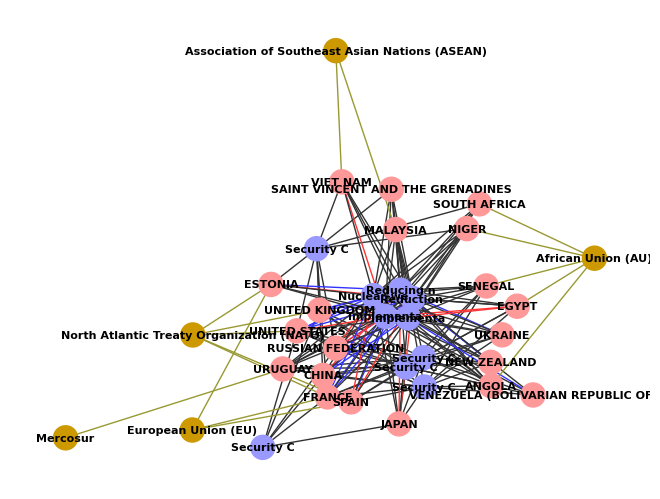

In [113]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Convert PyTorch Geometric data to a NetworkX graph
G = nx.Graph()

# Add nodes with titles
for i, resolution in enumerate(resolutions):
    if i >= cap_resolution:
        break
    G.add_node(get_resolution_idx(i), title=resolution[:10], color = node_colors_map[1], bipartite=0)

for i, voter in enumerate(voters):
    if i >= cap_voter:
        break
    G.add_node(get_voter_idx(i), title=voter, color = node_colors_map[0], bipartite=1)

for i, org_name in enumerate(org_index_list):
    if i >= cap_org:
        break
    G.add_node(get_org_idx(i), title=org_name, color = node_colors_map[2], bipartite=1)

# Add edges with colors based on edge features
for edge, edge_feature in zip(edge_index.t().tolist(), edge_features[0].tolist()):
    #print(edge, edge_feature)
    G.add_edge(edge[0], edge[1], color=edge_colors_map[int(edge_feature)])

# Draw the graph
left_nodes = [i for i in range(len_resolutions)] + [get_org_idx(i) for i in range(len_orgs)]
#pos = nx.bipartite_layout(G, nodes = left_nodes )  # You can use different layout algorithms
pos = nx.spring_layout(G, k=0.1, iterations=20)
edge_colors = [edge[2]['color'] for edge in G.edges(data=True)]
node_colors = [node[1]['color'] for node in G.nodes(data=True)]

labels = nx.get_node_attributes(G, 'title')

nx.draw(G, pos, with_labels=True, labels=labels, font_color='black', font_size=8, font_weight='bold', node_color=node_colors, edge_color=edge_colors, width=1, cmap=plt.cm.Blues)
plt.show()